In [1]:
print(0)

0


# importing python libraries

In [2]:
import os
# for file and directory operations

from PIL import Image
# image manipulation and loading 

from sklearn.model_selection import train_test_split
# train test validation split .7, .2, .1

import numpy as np
# numerical operations

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# encoding labels

import torch
# using neural networks

from torch.utils.data import Dataset, DataLoader
# NN has a dataloader format

import torch.nn as nn
# provides NN and its components

import torch.optim as optim
# optimization methods

from torchvision import models
# loads pretrained models

# for neural network operations
import torch.nn.functional as F

# plots graphs
import matplotlib.pyplot as plt

# creates classification report for all iamages
from sklearn.metrics import classification_report

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# loading the data 

In [3]:
# path to teh image folder, image and class lists
image_folder = "/home/pratyush/additional_work/Images"
image_data = []
class_labels = []

# Iterate through all class folders
for class_name in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_name)
    
    if os.path.isdir(class_path):
        
        # Iterate through all images in the class folder
        for image_name in os.listdir(class_path):
            if image_name.endswith(".tif"):
                image_path = os.path.join(class_path, image_name)
                
                # opening the image
                try:
                    with Image.open(image_path) as img:
                        
                        # Convert to RGB if not already in RGB
                        img = img.convert("RGB")
                        
                        # Resize the image to 224x224
                        img = img.resize((224, 224))
                        
                        # Convert the image to a NumPy array
                        img_array = np.array(img)
                        
                        # Append the image and its class label
                        image_data.append(img_array)
                        class_labels.append(class_name)
                        
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

# Print summary
print(f"Processed {len(image_data)} images.")
print(f"Class labels: {set(class_labels)}")

Processed 2100 images.
Class labels: {'chaparral', 'harbor', 'river', 'agricultural', 'forest', 'freeway', 'baseballdiamond', 'denseresidential', 'buildings', 'tenniscourt', 'storagetanks', 'mobilehomepark', 'golfcourse', 'runway', 'airplane', 'mediumresidential', 'parkinglot', 'intersection', 'overpass', 'sparseresidential', 'beach'}


In [4]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(image_data, class_labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test_encoded.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val_encoded.reshape(-1, 1))

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert image and label to tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, label
    
# Creating datasets and dataloaders
train_dataset = ImageDataset(x_train, y_train_one_hot)
val_dataset = ImageDataset(x_val, y_val_one_hot)
test_dataset = ImageDataset(x_test, y_test_one_hot)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)    

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

1470
420
210


# basic elements of the  model

In [6]:
# basic elements for all models
num_classes = len(set(class_labels))
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# alexnet model

In [7]:
# Loading Pretrained AlexNet model
model_alexnet = models.alexnet(pretrained=True)
model_alexnet.classifier[6] = nn.Linear(model_alexnet.classifier[6].in_features, num_classes)
optimizer_alexnet = optim.Adam(model_alexnet.parameters(), lr=0.00001)
model_alexnet.to(device)

# Track training and validation loss
alexnet_train_loss = []
alexnet_val_loss = []

# Training loop
for epoch in range(50):
    # Training phase
    model_alexnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_alexnet(images)
        loss = criterion(outputs, torch.argmax(labels, dim=1))

        # Backward pass and optimization
        optimizer_alexnet.zero_grad()
        loss.backward()
        optimizer_alexnet.step()

        running_loss += loss.item() * images.size(0)

    # Calculate epoch training loss
    epoch_train_loss = running_loss / len(train_loader.dataset)
    alexnet_train_loss.append(epoch_train_loss)

    # Validation phase
    model_alexnet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_alexnet(val_images)
            val_loss += criterion(val_outputs, torch.argmax(val_labels, dim=1)).item() * val_images.size(0)

    # Calculate epoch validation loss
    epoch_val_loss = val_loss / len(val_loader.dataset)
    alexnet_val_loss.append(epoch_val_loss)

    print(f"Epoch {epoch + 1}/50, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

print("Training completed.")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Training Loss: 2.7213, Validation Loss: 2.2513
Epoch 2/50, Training Loss: 1.7315, Validation Loss: 1.2269
Epoch 3/50, Training Loss: 0.9220, Validation Loss: 0.7444
Epoch 4/50, Training Loss: 0.6227, Validation Loss: 0.5969
Epoch 5/50, Training Loss: 0.4640, Validation Loss: 0.4867
Epoch 6/50, Training Loss: 0.3541, Validation Loss: 0.4276
Epoch 7/50, Training Loss: 0.2758, Validation Loss: 0.4049
Epoch 8/50, Training Loss: 0.2273, Validation Loss: 0.3704
Epoch 9/50, Training Loss: 0.1822, Validation Loss: 0.3593
Epoch 10/50, Training Loss: 0.1498, Validation Loss: 0.3225
Epoch 11/50, Training Loss: 0.1270, Validation Loss: 0.3279
Epoch 12/50, Training Loss: 0.1100, Validation Loss: 0.2943
Epoch 13/50, Training Loss: 0.0982, Validation Loss: 0.2795
Epoch 14/50, Training Loss: 0.0659, Validation Loss: 0.2743
Epoch 15/50, Training Loss: 0.0598, Validation Loss: 0.2494
Epoch 16/50, Training Loss: 0.0523, Validation Loss: 0.2821
Epoch 17/50, Training Loss: 0.0434, Validation Lo

# VGG model

In [8]:
# Loading Pretrained VGG-16 model 
model_vgg16 = models.vgg16(pretrained=True)
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, num_classes)
optimizer_vgg16 = optim.Adam(model_vgg16.parameters(), lr=0.00001)
model_vgg16.to(device)

# Track training and validation losses
vgg16_train_loss = []
vgg16_val_loss = []

# Training loop
for epoch in range(50):
    # Training phase
    model_vgg16.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_vgg16(images)
        loss = criterion(outputs, torch.argmax(labels, dim=1))

        # Backward pass and optimization
        optimizer_vgg16.zero_grad()
        loss.backward()
        optimizer_vgg16.step()

        running_loss += loss.item() * images.size(0)

    # Calculate epoch training loss
    epoch_train_loss = running_loss / len(train_loader.dataset)
    vgg16_train_loss.append(epoch_train_loss)

    # Validation phase
    model_vgg16.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_vgg16(val_images)
            val_loss += criterion(val_outputs, torch.argmax(val_labels, dim=1)).item() * val_images.size(0)

    # Calculate epoch validation loss
    epoch_val_loss = val_loss / len(val_loader.dataset)
    vgg16_val_loss.append(epoch_val_loss)

    print(f"Epoch {epoch + 1}/50, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

print("Training completed.")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Training Loss: 2.7800, Validation Loss: 2.1202
Epoch 2/50, Training Loss: 1.3672, Validation Loss: 0.6256
Epoch 3/50, Training Loss: 0.6169, Validation Loss: 0.3372
Epoch 4/50, Training Loss: 0.3600, Validation Loss: 0.2669
Epoch 5/50, Training Loss: 0.2479, Validation Loss: 0.2109
Epoch 6/50, Training Loss: 0.1587, Validation Loss: 0.2068
Epoch 7/50, Training Loss: 0.1217, Validation Loss: 0.2348
Epoch 8/50, Training Loss: 0.1011, Validation Loss: 0.1955
Epoch 9/50, Training Loss: 0.0642, Validation Loss: 0.2071
Epoch 10/50, Training Loss: 0.0517, Validation Loss: 0.1532
Epoch 11/50, Training Loss: 0.0339, Validation Loss: 0.2023
Epoch 12/50, Training Loss: 0.0290, Validation Loss: 0.1743
Epoch 13/50, Training Loss: 0.0208, Validation Loss: 0.1828
Epoch 14/50, Training Loss: 0.0286, Validation Loss: 0.1698
Epoch 15/50, Training Loss: 0.0229, Validation Loss: 0.1968
Epoch 16/50, Training Loss: 0.0142, Validation Loss: 0.1868
Epoch 17/50, Training Loss: 0.0181, Validation Lo

# resnet model

In [9]:
# ResNet-18 model
model_resnet18 = models.resnet18(pretrained=True)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, num_classes)
optimizer_resnet18 = optim.Adam(model_resnet18.parameters(), lr=0.00001)
model_resnet18.to(device)

# Track training and validation losses
resnet18_train_loss = []
resnet18_val_loss = []

# Training loop
for epoch in range(50):
    # Training phase
    model_resnet18.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_resnet18(images)
        loss = criterion(outputs, torch.argmax(labels, dim=1))

        # Backward pass and optimization
        optimizer_resnet18.zero_grad()
        loss.backward()
        optimizer_resnet18.step()

        running_loss += loss.item() * images.size(0)

    # Calculate epoch training loss
    epoch_train_loss = running_loss / len(train_loader.dataset)
    resnet18_train_loss.append(epoch_train_loss)

    # Validation phase
    model_resnet18.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_resnet18(val_images)
            val_loss += criterion(val_outputs, torch.argmax(val_labels, dim=1)).item() * val_images.size(0)

    # Calculate epoch validation loss
    epoch_val_loss = val_loss / len(val_loader.dataset)
    resnet18_val_loss.append(epoch_val_loss)

    print(f"Epoch {epoch + 1}/50, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

print("Training completed.")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Training Loss: 2.8943, Validation Loss: 2.5711
Epoch 2/50, Training Loss: 2.1044, Validation Loss: 1.9536
Epoch 3/50, Training Loss: 1.5232, Validation Loss: 1.4728
Epoch 4/50, Training Loss: 1.1200, Validation Loss: 1.1109
Epoch 5/50, Training Loss: 0.8298, Validation Loss: 0.8732
Epoch 6/50, Training Loss: 0.6549, Validation Loss: 0.7002
Epoch 7/50, Training Loss: 0.5192, Validation Loss: 0.5820
Epoch 8/50, Training Loss: 0.3956, Validation Loss: 0.5119
Epoch 9/50, Training Loss: 0.3337, Validation Loss: 0.4371
Epoch 10/50, Training Loss: 0.2757, Validation Loss: 0.3908
Epoch 11/50, Training Loss: 0.2492, Validation Loss: 0.3448
Epoch 12/50, Training Loss: 0.2085, Validation Loss: 0.3074
Epoch 13/50, Training Loss: 0.1718, Validation Loss: 0.2824
Epoch 14/50, Training Loss: 0.1496, Validation Loss: 0.2775
Epoch 15/50, Training Loss: 0.1223, Validation Loss: 0.2388
Epoch 16/50, Training Loss: 0.1122, Validation Loss: 0.2322
Epoch 17/50, Training Loss: 0.0990, Validation Lo

Epoch 23/50, Training Loss: 0.0518, Validation Loss: 0.1605
Epoch 24/50, Training Loss: 0.0444, Validation Loss: 0.1550
Epoch 25/50, Training Loss: 0.0460, Validation Loss: 0.1529
Epoch 26/50, Training Loss: 0.0427, Validation Loss: 0.1398
Epoch 27/50, Training Loss: 0.0387, Validation Loss: 0.1460
Epoch 28/50, Training Loss: 0.0356, Validation Loss: 0.1337
Epoch 29/50, Training Loss: 0.0315, Validation Loss: 0.1342
Epoch 30/50, Training Loss: 0.0327, Validation Loss: 0.1254
Epoch 31/50, Training Loss: 0.0289, Validation Loss: 0.1253
Epoch 32/50, Training Loss: 0.0303, Validation Loss: 0.1239
Epoch 33/50, Training Loss: 0.0271, Validation Loss: 0.1176
Epoch 34/50, Training Loss: 0.0255, Validation Loss: 0.1142
Epoch 35/50, Training Loss: 0.0230, Validation Loss: 0.1151
Epoch 36/50, Training Loss: 0.0211, Validation Loss: 0.1155
Epoch 37/50, Training Loss: 0.0218, Validation Loss: 0.1105
Epoch 38/50, Training Loss: 0.0205, Validation Loss: 0.1088
Epoch 39/50, Training Loss: 0.0170, Vali

# CBAM model

In [ ]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        
        # Average pool
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        
        # Max pool
        max_out = self.fc(self.max_pool(x).view(b, c))
        
        # Combine outputs and apply sigmoid
        out = avg_out + max_out
        out = self.sigmoid(out).view(b, c, 1, 1)
        
        return x * out

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        
        # Concatenate average and max
        out = torch.cat([avg_out, max_out], dim=1)
        
        # Apply convolution and sigmoid
        out = self.conv(out)
        return x * self.sigmoid(out)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class SimpleCBAMCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCBAMCNN, self).__init__()
        
        # Convolutional layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.cbam1 = CBAM(32)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)

        # Global average pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
num_classes = len(set(class_labels))
model_cbam = SimpleCBAMCNN(num_classes=num_classes).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cbam.parameters(), lr=0.0001)

cbam_train_loss = []
cbam_val_loss = []

num_epochs = 300

# Training loop
for epoch in range(num_epochs):
    model_cbam.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_cbam(images)
        loss = criterion(outputs, torch.argmax(labels, dim=1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    cbam_train_loss.append(epoch_train_loss)

    # Validation
    model_cbam.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_cbam(val_images)
            val_loss += criterion(val_outputs, torch.argmax(val_labels, dim=1)).item() * val_images.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    cbam_val_loss.append(epoch_val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

print("Training completed.")

Epoch 1/300, Training Loss: 3.0458, Validation Loss: 3.0523
Epoch 2/300, Training Loss: 3.0410, Validation Loss: 3.0487
Epoch 3/300, Training Loss: 3.0369, Validation Loss: 3.0441
Epoch 4/300, Training Loss: 3.0330, Validation Loss: 3.0391


Epoch 5/300, Training Loss: 3.0283, Validation Loss: 3.0342
Epoch 6/300, Training Loss: 3.0235, Validation Loss: 3.0285
Epoch 7/300, Training Loss: 3.0191, Validation Loss: 3.0235
Epoch 8/300, Training Loss: 3.0144, Validation Loss: 3.0181
Epoch 9/300, Training Loss: 3.0099, Validation Loss: 3.0128
Epoch 10/300, Training Loss: 3.0045, Validation Loss: 3.0070
Epoch 11/300, Training Loss: 3.0000, Validation Loss: 2.9999
Epoch 12/300, Training Loss: 2.9939, Validation Loss: 2.9951
Epoch 13/300, Training Loss: 2.9893, Validation Loss: 2.9890
Epoch 14/300, Training Loss: 2.9846, Validation Loss: 2.9836
Epoch 15/300, Training Loss: 2.9805, Validation Loss: 2.9799
Epoch 16/300, Training Loss: 2.9752, Validation Loss: 2.9723
Epoch 17/300, Training Loss: 2.9701, Validation Loss: 2.9684
Epoch 18/300, Training Loss: 2.9663, Validation Loss: 2.9647
Epoch 19/300, Training Loss: 2.9627, Validation Loss: 2.9622
Epoch 20/300, Training Loss: 2.9580, Validation Loss: 2.9556
Epoch 21/300, Training Loss: 

# results

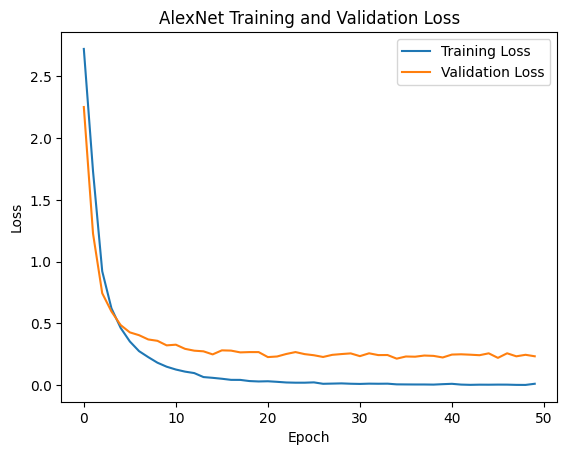

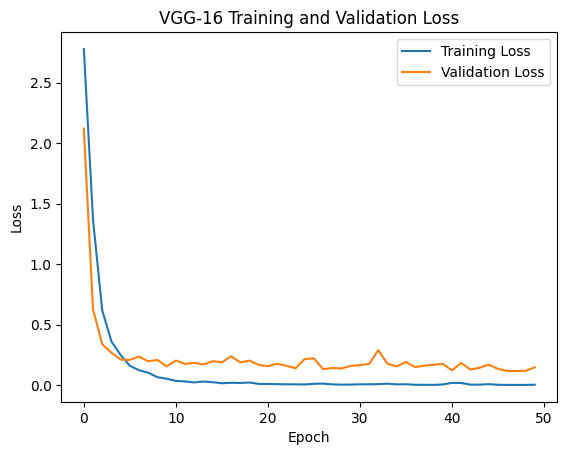

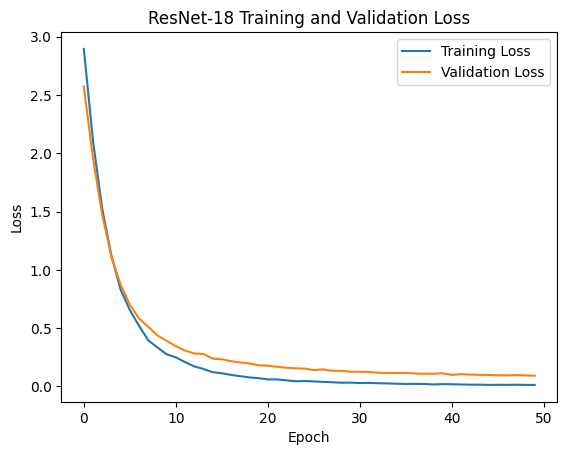

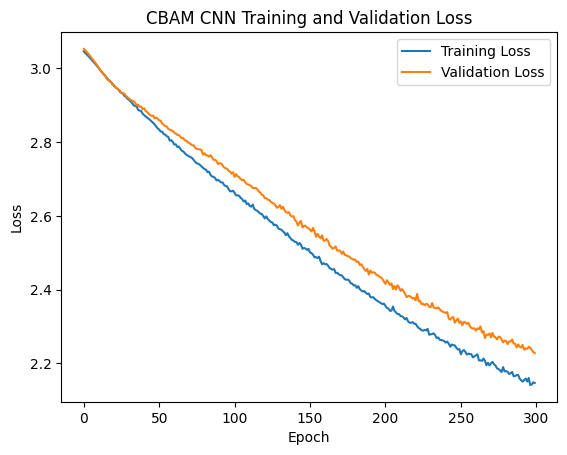

In [11]:
# Plotting the training and validation losses
def plot_losses(train_losses, val_losses, model_name):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plotting for each model
plot_losses(alexnet_train_loss, alexnet_val_loss, "AlexNet")
plot_losses(vgg16_train_loss, vgg16_val_loss, "VGG-16")
plot_losses(resnet18_train_loss, resnet18_val_loss, "ResNet-18")
plot_losses(cbam_train_loss, cbam_val_loss, "CBAM CNN")

In [14]:
# Function to get predictions from the test loader
def get_predictions(model, loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            
            # If labels are one-hot encoded, convert them to class indices
            labels = torch.argmax(labels, axis=1).to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class (highest probability)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# Ensure the models are moved to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_alexnet.to(device)
model_vgg16.to(device)
model_resnet18.to(device)
model_cbam.to(device)

# Test each model on the test loader
alexnet_labels, alexnet_preds = get_predictions(model_alexnet, test_loader, device)
vgg16_labels, vgg16_preds = get_predictions(model_vgg16, test_loader, device)
resnet18_labels, resnet18_preds = get_predictions(model_resnet18, test_loader, device)
cbam_labels, cbam_preds = get_predictions(model_cbam, test_loader, device)

print()
print()
print()

# Generate classification reports for each model
print("AlexNet Classification Report")
print(classification_report(alexnet_labels, alexnet_preds))

print("VGG-16 Classification Report")
print(classification_report(vgg16_labels, vgg16_preds))

print("ResNet-18 Classification Report")
print(classification_report(resnet18_labels, resnet18_preds))

print("CBAM CNN Classification Report")
print(classification_report(cbam_labels, cbam_preds))





AlexNet Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       0.95      0.91      0.93        23
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       0.82      0.88      0.85        16
           5       1.00      1.00      1.00        18
           6       0.82      0.69      0.75        26
           7       1.00      0.88      0.94        17
           8       1.00      0.96      0.98        27
           9       0.93      0.82      0.87        17
          10       1.00      0.94      0.97        18
          11       0.85      0.94      0.89        18
          12       0.71      0.80      0.75        15
          13       0.93      1.00      0.96        26
          14       1.00      0.93      0.96        14
          15       0.96      1.00      0.98        24
          16       0.81      0.94      0.87     